<h1>Разработка модели классификации на фродовые заказы</h1>

<h2>1. Сборка окружения и загрузка данных</h2>

In [1]:
# Установка библиотек
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn \
                tensorflow xgboost lightgbm catboost




[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Импортируем все необходимое
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


In [3]:
# Считываем данные и проверяем их на наличие пропусков

df_train = pd.read_csv("df_train.csv")
df_test  = pd.read_csv("df_test.csv")

print(f"df_train {df_train.shape}")
print(df_train.info())

df_train (105565, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   CreatedDate                    105565 non-null  object 
 3   service                        105565 non-null  object 
 4   total_ordered                  105565 non-null  int64  
 5   PaymentType                    105565 non-null  object 
 6   IsPaid                         105565 non-null  bool   
 7   count_items                    105565 non-null  int64  
 8   unique_items                   105565 non-null  int64  
 9   avg_unique_purchase            105565 non-null  float64
 10  is_courier                     105565 non-null  int64  
 11  NmAge                          105565 non-null  int64  
 12  Distance

<p>Всего 105565 строк, 21 колонка, 3 из которых строковые, 1 булевая, остальные являются числовыми</p>
<p>Также отсутствуют пропуски данных</p>

<h2>2. Анализ данных (EDA)</h2>

<h3>2.1 Исследуем распределение признаков</h3>

<h4>2.1.1 Общие сведения</h4>

In [4]:
display(df_train.head(), df_train.describe().T)

,user_id,nm_id,CreatedDate,service,total_ordered,PaymentType,IsPaid,count_items,unique_items,avg_unique_purchase,...,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target
0,1,1,2025-01-05 02:20:24+03:00,nnsz,627,CSH,False,4,4,1.00,...,117,3443,73,1,627,627.0,627,627,100.000000,0
1,2,2,2024-11-05 09:05:21+03:00,nnsz,512,CRD,True,0,0,0.00,...,920,3478,1237,2,606,303.0,94,512,50.000000,0
2,3,3,2024-12-11 13:45:33+03:00,nnsz,500,CRD,True,0,0,0.00,...,420,771,4003,1,500,500.0,500,500,100.000000,0
3,4,4,2025-01-24 07:47:34+03:00,nnsz,452,CSH,False,6,2,0.33,...,20112,763,977,5,1102,220.4,100,452,20.000000,0
4,5,5,2024-11-27 11:50:43+03:00,nnsz,450,CRD,True,0,0,0.00,...,141,1089,1637,3,549,183.0,1,450,33.333333,0


,count,mean,std,min,25%,50%,75%,max
user_id,105565.0,21169.816056,12481.936785,1.000000,9399.000000,22640.000000,34319.00,35433.0
nm_id,105565.0,19504.235305,13426.109359,1.000000,6057.000000,20774.000000,33684.00,37224.0
total_ordered,105565.0,30.262322,40.532477,1.000000,1.000000,14.000000,50.00,627.0
count_items,105565.0,256.541562,1023.116291,0.000000,0.000000,22.000000,107.00,203303.0
unique_items,105565.0,34.933851,141.116667,0.000000,0.000000,13.000000,39.00,19984.0
avg_unique_purchase,105565.0,0.403886,0.406656,0.000000,0.000000,0.250000,0.86,1.0
is_courier,105565.0,0.013243,0.114314,0.000000,0.000000,0.000000,0.00,1.0
NmAge,105565.0,5518.167887,8667.012801,0.000000,153.000000,363.000000,20004.00,20120.0
Distance,105565.0,1554.587572,1657.277528,6.000000,472.000000,1066.000000,1995.00,13381.0
DaysAfterRegistration,105565.0,1368.405589,995.599647,0.000000,551.000000,1344.000000,1843.00,5839.0


<p>У total_ordered медиана 14, когда максимум 37224, это странно, похожие странности встречаются у count_items, unique_items, также возможно важными будут признаки Distance, DaysAfterRegistration, где максимальные в несколько раз больше средних</p>

<h4>2.1.2 Гистограммы</h4>

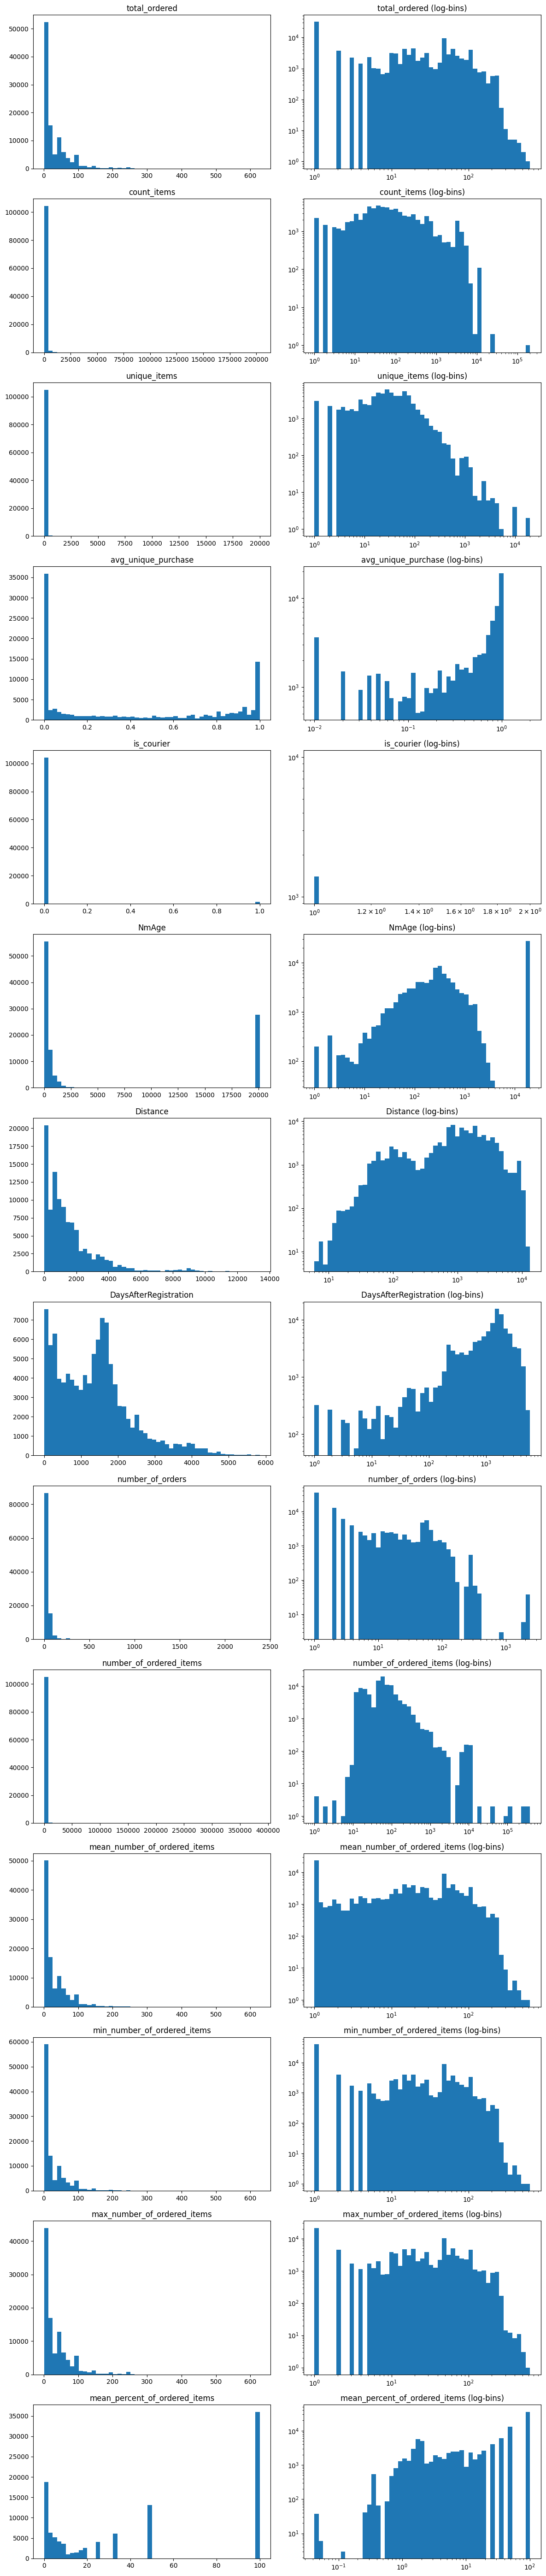

In [5]:
import numpy as np
import matplotlib.pyplot as plt

numeric = [c for c in df_train.select_dtypes(['int64','float64']).columns 
           if c not in ['user_id','nm_id','target']]

def log_bins(arr, bins=50):
    mn = arr[arr>0].min()
    mx = arr.max()
    return np.logspace(np.log10(mn), np.log10(mx+1), bins)

fig, axes = plt.subplots(len(numeric), 2, figsize=(12, 4*len(numeric)))
for i, col in enumerate(numeric):
    arr = df_train[col].dropna()
    axes[i,0].hist(arr, bins=50)
    axes[i,0].set_title(col)
    if (arr>0).any():
        axes[i,1].hist(arr[arr>0], bins=log_bins(arr), log=True)
        axes[i,1].set_xscale('log')
        axes[i,1].set_title(f'{col} (log-bins)')
    else:
        axes[i,1].text(0.5,0.5,'нет >0',ha='center')
plt.tight_layout()
plt.show()


<h4>2.1.3 Boxplot</h4>

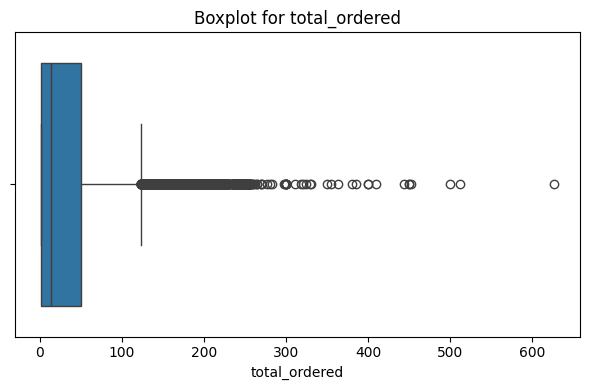

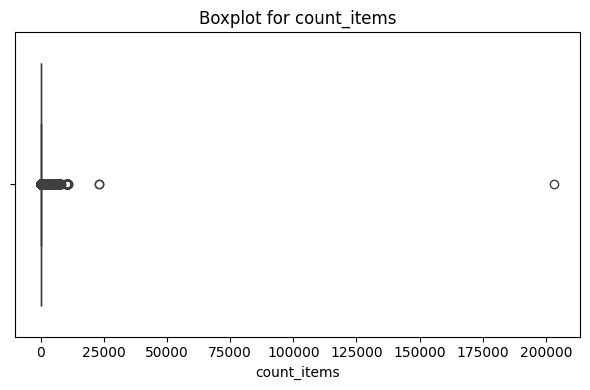

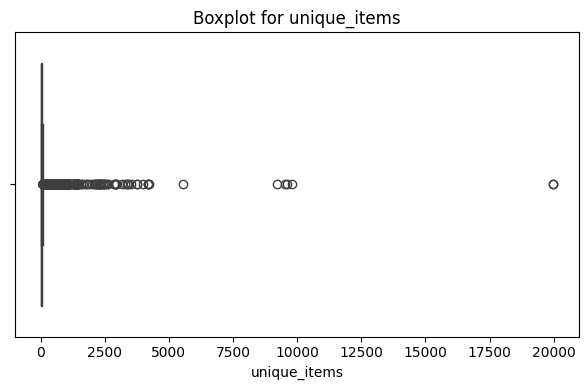

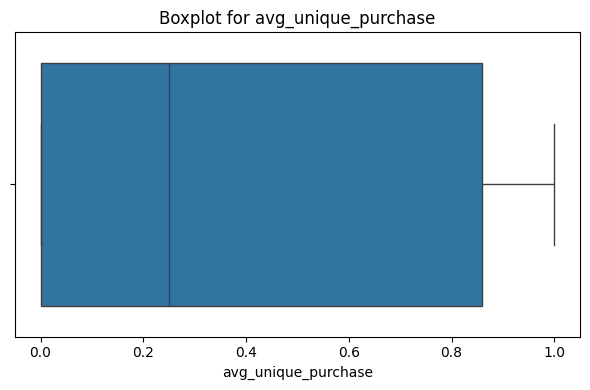

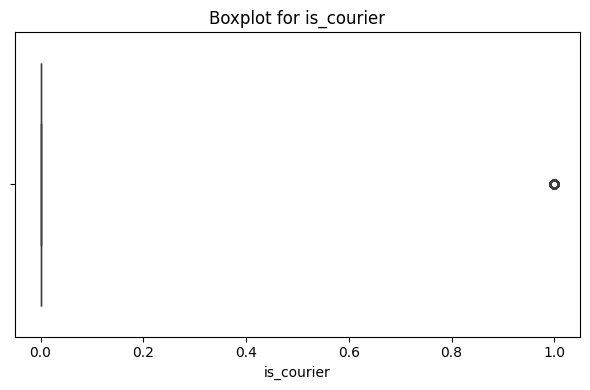

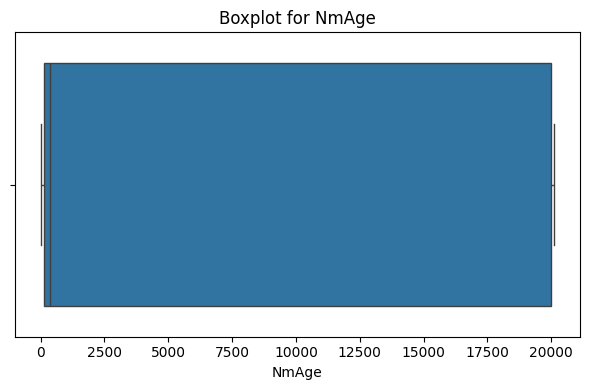

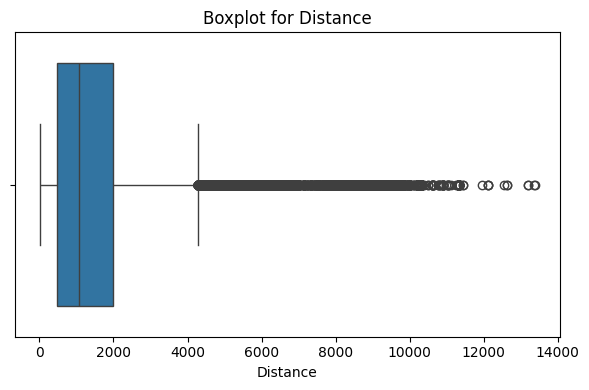

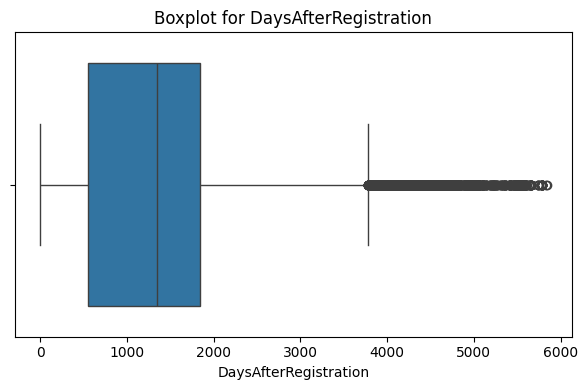

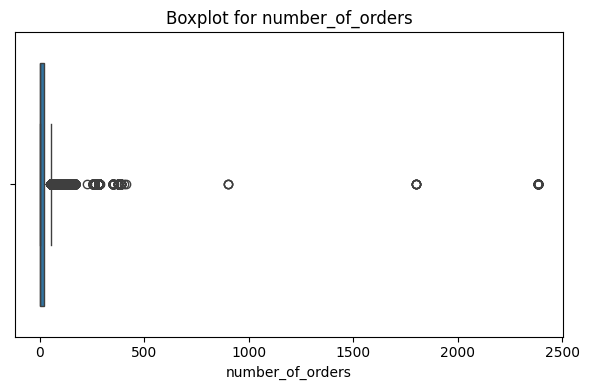

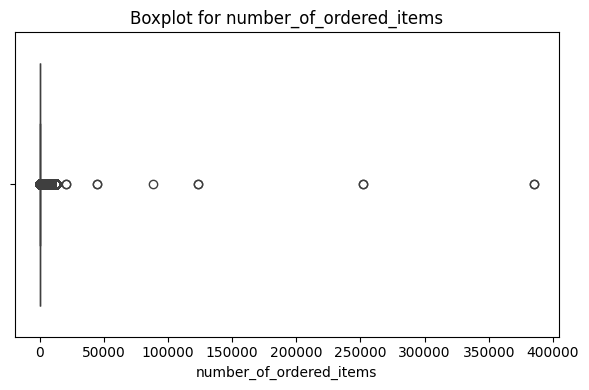

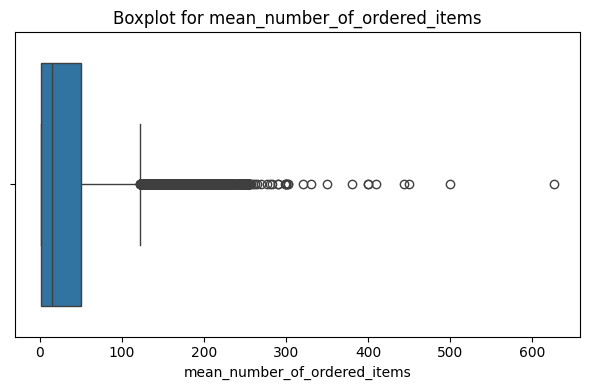

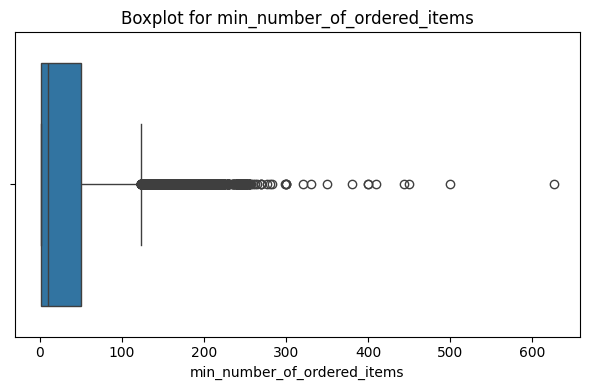

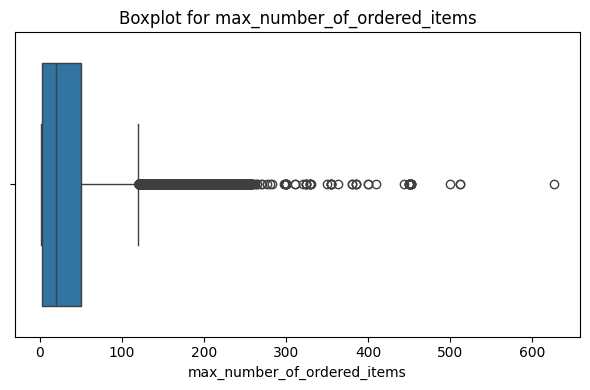

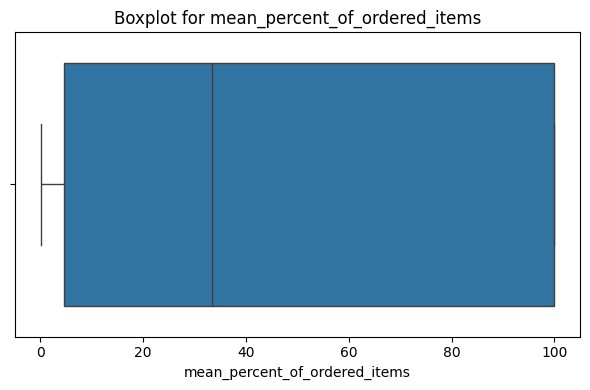

In [6]:
for col in numeric:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()
    plt.show()

<h3>2.2 Дисбаланс классов</h3>

In [7]:
print(df_train['target'].value_counts(), "\n")
print(df_train['target'].value_counts(normalize=True).rename("share").to_frame(), "\n")

target
0    92211
1    13354
Name: count, dtype: int64 

         share
target        
0       0.8735
1       0.1265 



<p>Класс с меткой 1 встречается всего в 13354 случаях, что является 12.65% от всей выборки, так что у нас выраженный дисбаланс классов</p>

<h3>2.3 Корреляция между признаками</h3>

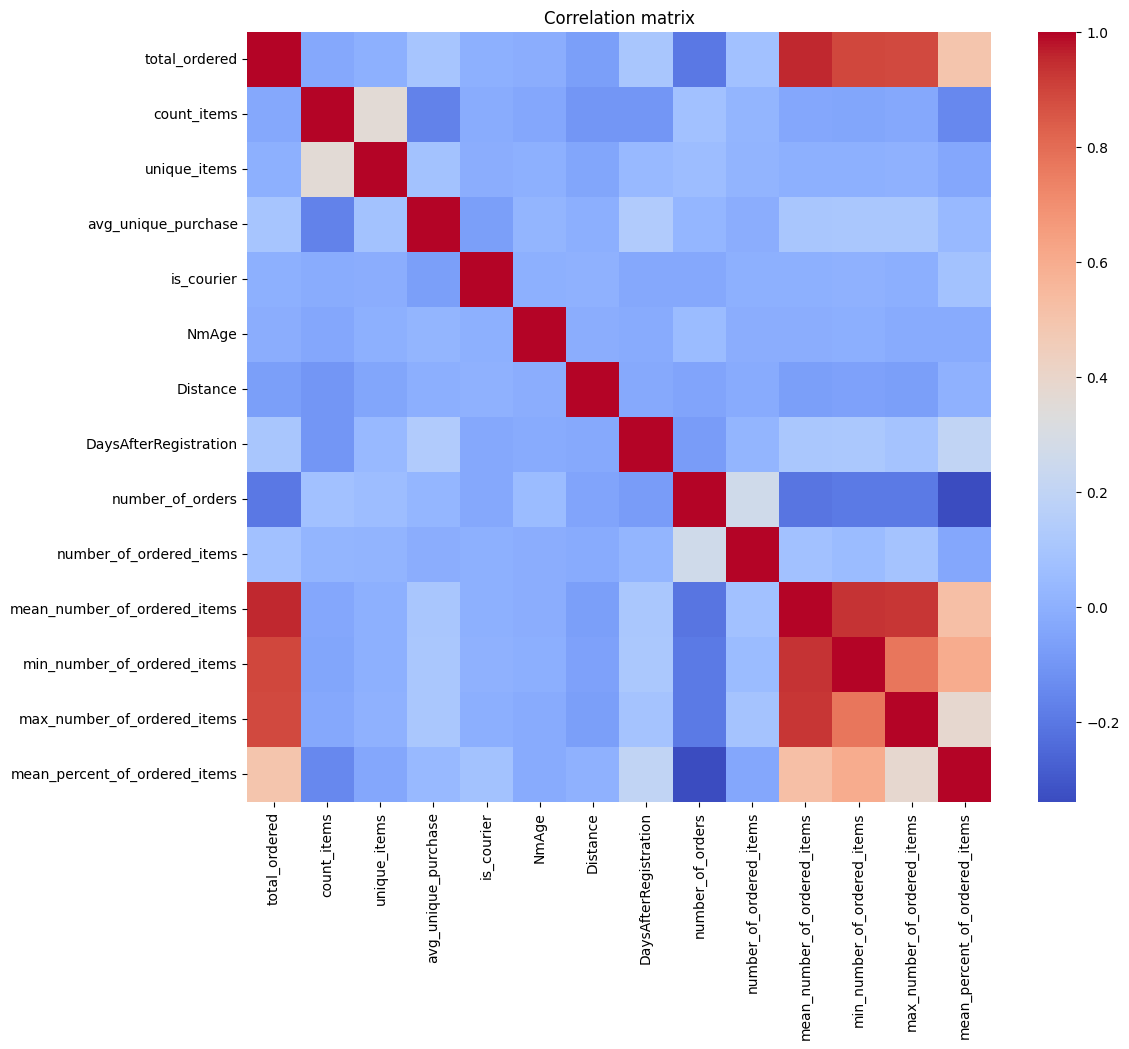

,total_ordered,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items
total_ordered,1.000000,-0.035300,-0.003398,0.099678,0.000702,-0.013033,-0.067591,0.103316,-0.198469,0.075877,0.954879,0.891371,0.887398,0.495369
count_items,-0.035300,1.000000,0.357917,-0.168657,-0.019929,-0.038946,-0.102444,-0.099472,0.078189,0.020035,-0.037421,-0.043728,-0.032798,-0.147801
unique_items,-0.003398,0.357917,1.000000,0.081079,-0.014558,-0.002939,-0.045009,0.041497,0.056560,0.013689,-0.003639,-0.000140,0.003034,-0.040384
avg_unique_purchase,0.099678,-0.168657,0.081079,1.000000,-0.070605,0.016895,-0.009004,0.135716,0.024549,-0.014009,0.104854,0.107012,0.107812,0.039596
is_courier,0.000702,-0.019929,-0.014558,-0.070605,1.000000,-0.000717,0.003854,-0.033269,-0.035346,-0.003250,0.000480,0.001614,-0.009184,0.082117
NmAge,-0.013033,-0.038946,-0.002939,0.016895,-0.000717,1.000000,-0.013278,-0.020748,0.048963,-0.010713,-0.013714,-0.006444,-0.023986,-0.022489
Distance,-0.067591,-0.102444,-0.045009,-0.009004,0.003854,-0.013278,1.000000,-0.027019,-0.048285,-0.023657,-0.070131,-0.058649,-0.069656,0.002776
DaysAfterRegistration,0.103316,-0.099472,0.041497,0.135716,-0.033269,-0.020748,-0.027019,1.000000,-0.078708,0.021201,0.108771,0.115730,0.089542,0.204851
number_of_orders,-0.198469,0.078189,0.056560,0.024549,-0.035346,0.048963,-0.048285,-0.078708,1.000000,0.263163,-0.208429,-0.195700,-0.197636,-0.339107
number_of_ordered_items,0.075877,0.020035,0.013689,-0.014009,-0.003250,-0.010713,-0.023657,0.021201,0.263163,1.000000,0.079036,0.049994,0.088164,-0.039427


In [8]:
corr = df_train[numeric].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation matrix')
plt.show()
df_train[numeric].corr()

<h3>2.4 Проверка на наличие пропущенных значений и выбросы</h3>

На 1 этапе было выявлено что отсутствуют пропущенные данные

In [9]:
outliers = {}
for col in numeric:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    mask = (df_train[col] < lower) | (df_train[col] > upper)
    outliers[col] = mask.sum()

# Топ-5 признаков по числу выбросов
import pandas as pd
pd.Series(outliers).sort_values(ascending=False).head()


count_items                16217
number_of_orders           13728
number_of_ordered_items     9139
unique_items                7221
Distance                    6143
dtype: int64

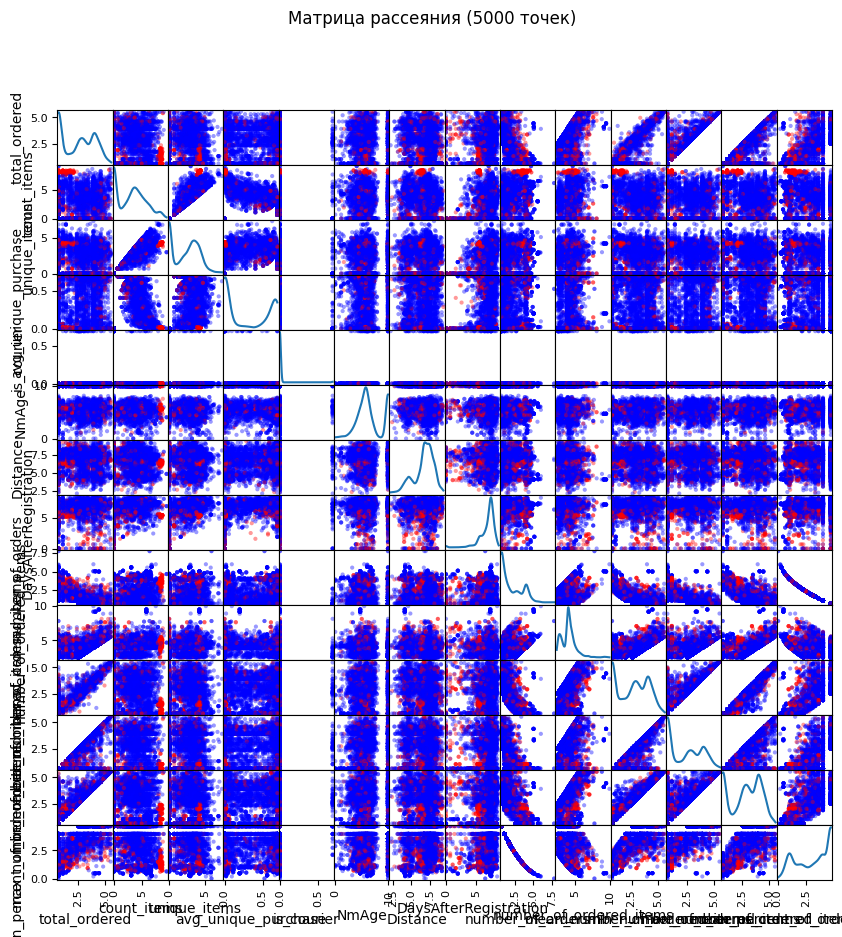

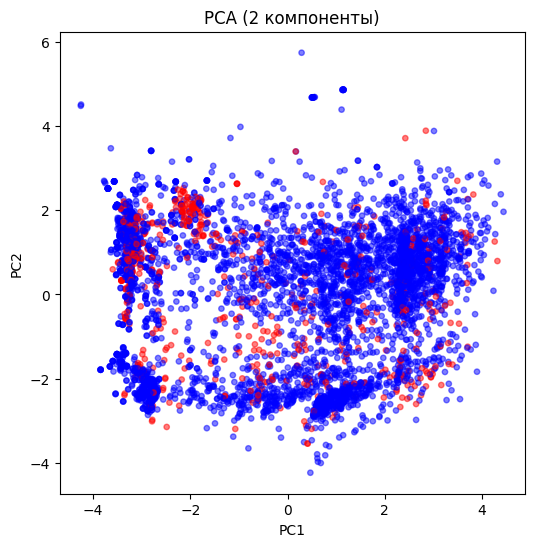

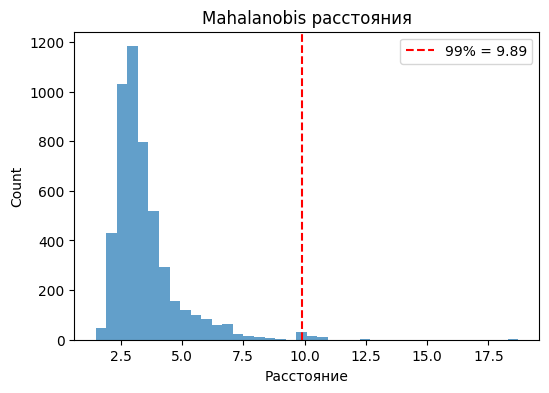

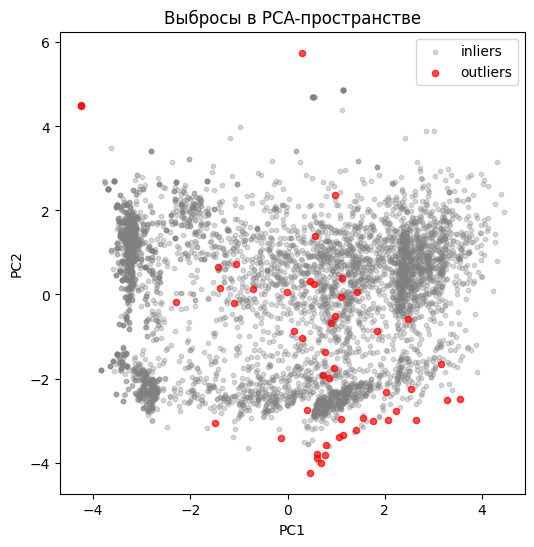

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy import linalg



logd = np.log1p(df_train[numeric])
col_target = df_train['target'].map({0:'blue',1:'red'})

sample = logd.sample(5000, random_state=42)
colors = df_train.loc[sample.index, 'target'].map({0:'blue',1:'red'})

scatter_matrix(sample, diagonal='kde', alpha=0.4, figsize=(10,10), color=colors)
plt.suptitle('Матрица рассеяния (5000 точек)')
plt.show()

X = StandardScaler().fit_transform(sample)
pc = PCA(2).fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(pc[:,0], pc[:,1], c=colors, alpha=0.5, s=15)
plt.title('PCA (2 компоненты)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

cov = np.cov(X, rowvar=False)
inv_cov = linalg.inv(cov)
mean = X.mean(axis=0)
md = np.array([mahalanobis(x, mean, inv_cov) for x in X])
thr = np.percentile(md, 99)

plt.figure(figsize=(6,4))
plt.hist(md, bins=40, alpha=0.7)
plt.axvline(thr, color='red', linestyle='--', label=f'99% = {thr:.2f}')
plt.title('Mahalanobis расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Count')
plt.legend()
plt.show()

out = md > thr
plt.figure(figsize=(6,6))
plt.scatter(pc[~out,0], pc[~out,1], c='grey', alpha=0.3, s=10, label='inliers')
plt.scatter(pc[out,0], pc[out,1], c='red', alpha=0.7, s=20, label='outliers')
plt.title('Выбросы в PCA-пространстве')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


<h3>2.5 Связь таргера с признаками</h3>

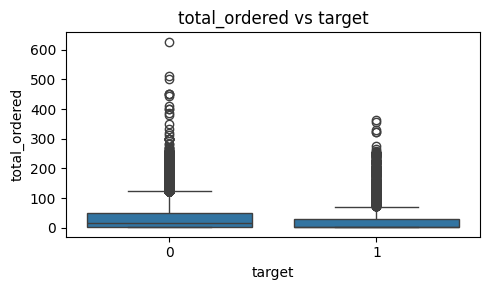

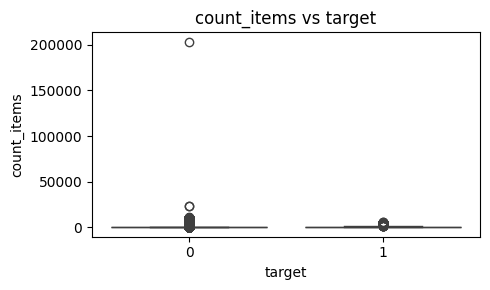

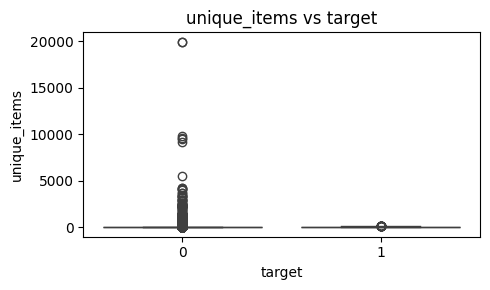

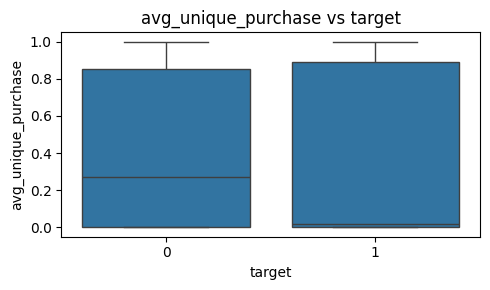

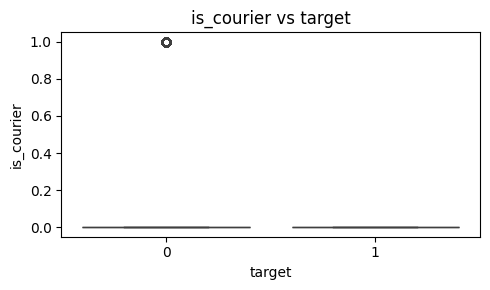

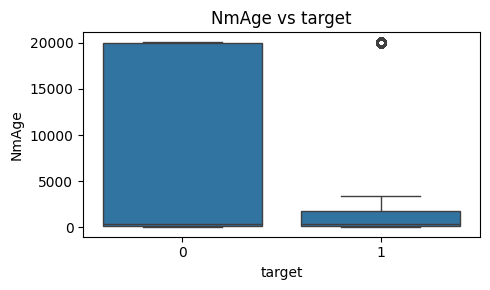

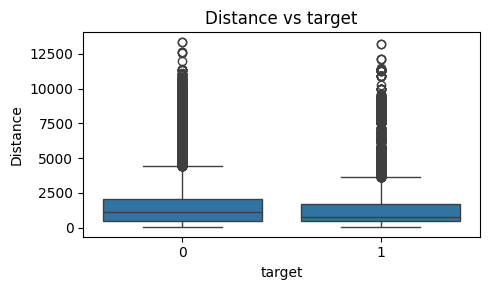

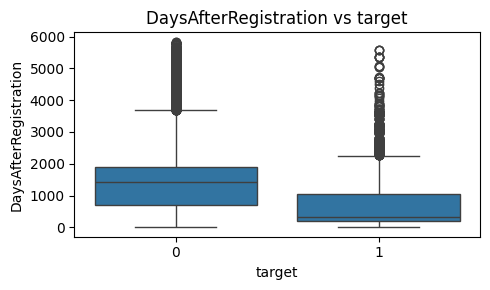

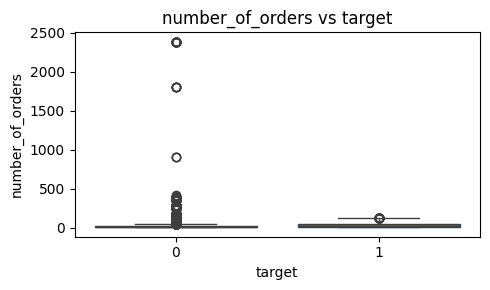

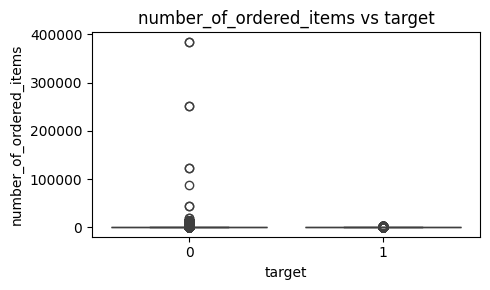

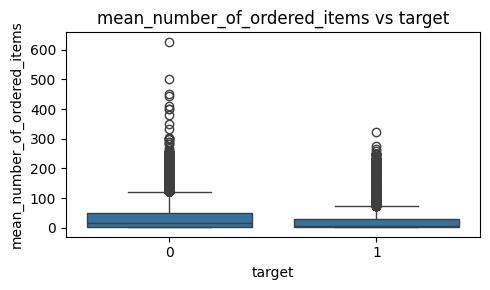

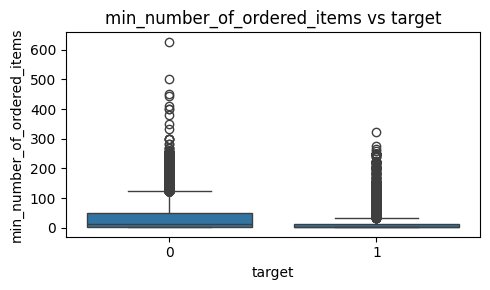

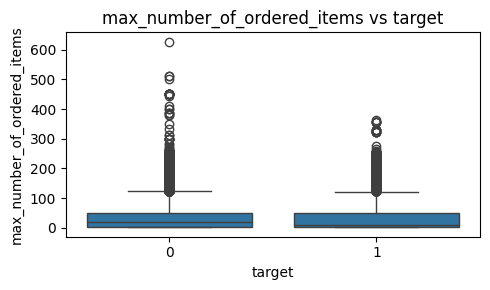

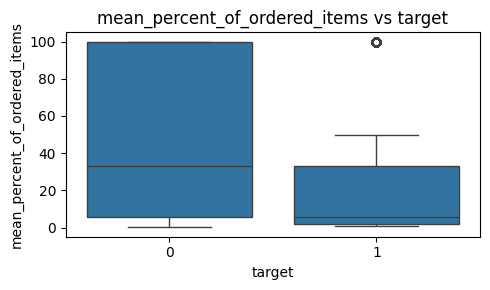

In [11]:
for col in numeric:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='target', y=col, data=df_train)
    plt.title(f'{col} vs target')
    plt.tight_layout()
    plt.show()

target,0,1
service,,
nnsz,0.889655,0.110345
ordo,0.866769,0.133231


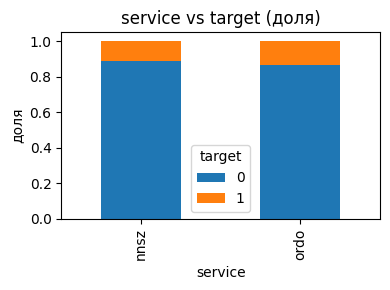

target,0,1
PaymentType,,
ACC,1.000000,0.000000
BAL,0.906186,0.093814
CIN,1.000000,0.000000
CRD,0.834435,0.165565
CRE,0.949153,0.050847
CSH,0.882632,0.117368
CWB,1.000000,0.000000
MPM,0.892710,0.107290
PDL,1.000000,0.000000


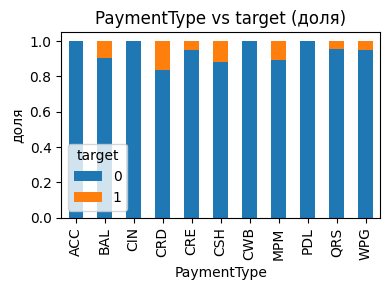

target,0,1
is_courier,,
0,0.871802,0.128198
1,1.000000,0.000000


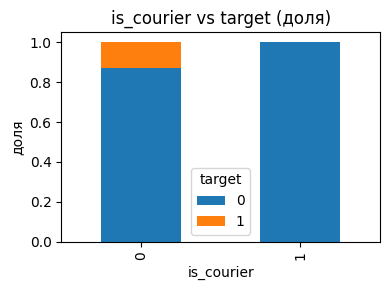

target,0,1
IsPaid,,
False,0.881481,0.118519
True,0.858447,0.141553


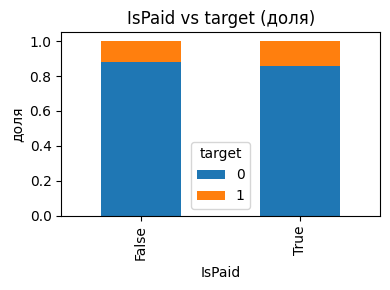

In [12]:
import pandas as pd

for cat in ['service', 'PaymentType', 'is_courier', 'IsPaid']:
    ct = pd.crosstab(df_train[cat], df_train['target'], normalize='index')
    display(ct)
    ct.plot(kind='bar', stacked=True, figsize=(4,3))
    plt.title(f'{cat} vs target (доля)')
    plt.ylabel('доля')
    plt.tight_layout()
    plt.show()


<h2>3. Предобработка данных</h2>

<h3>3.1 Удалим 1 % аномальных точек</h3>


In [13]:
from scipy.spatial.distance import mahalanobis
from scipy import linalg
from sklearn.preprocessing import StandardScaler

numeric = [
    'total_ordered','count_items','unique_items','Distance',
    'DaysAfterRegistration','number_of_orders',
    'number_of_ordered_items','mean_number_of_ordered_items',
    'min_number_of_ordered_items','max_number_of_ordered_items'
]

X_num = df_train[numeric].values
Xs    = StandardScaler().fit_transform(X_num)
cov_inv = linalg.inv(np.cov(Xs, rowvar=False))
mean    = Xs.mean(axis=0)
md      = np.array([mahalanobis(x, mean, cov_inv) for x in Xs])
thr     = np.percentile(md, 98.6)
mask    = md <= thr

print(f"Удаляем { (~mask).sum() } строк (~{100*(~mask).mean():.2f}%)")
df_train = df_train.loc[mask].reset_index(drop=True)

Удаляем 1478 строк (~1.40%)


<h3>3.2 Преобразование категориальных и булевых признаков</h2>

In [14]:
for df in (df_train, df_test):
    for col in numeric:
        df[col] = np.log1p(df[col])

#Приводим CreateDate к datetime, а IsPaid и is_courier к int
for df in (df_train, df_test):
    df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], utc=True)
    df['IsPaid'] = df['IsPaid'].astype(int)
    df['is_courier'] = df['is_courier'].astype(int)


for df in (df_train, df_test):
    df['hour'] = df['CreatedDate'].dt.hour



df_train['temp'] = 0
df_test['temp'] = 1
full = pd.concat([df_train, df_test], axis=0)
#Делаем для service и PaymentType One Hot encoding
full = pd.get_dummies(full, columns=['service', 'PaymentType', 'hour'], drop_first=False)
df_train = full[full['temp'] == 0].drop(columns='temp')
df_test = full[full['temp'] == 1].drop(columns='temp')


<h3>3.3 Масштабирование числовых признаков</h3>

In [15]:
from sklearn.preprocessing import StandardScaler
features = [c for c in df_train.columns if c not in ['target', 'user_id','nm_id', 'CreatedDate']]
scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])


avg_cols = [col for col in df_train.columns if col not in ['target']]
for df in (df_train, df_test):
    df[avg_cols] = df.groupby('user_id')[avg_cols].transform('mean')
#Удаляем лишние столбцы
for df in (df_train, df_test):
    df.drop(columns=['user_id','nm_id', 'CreatedDate'], inplace=True)

In [16]:
#Разделяем данные
y = df_train['target']
X = df_train.drop(columns='target')

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<h2>4. Построение модели</h2>

<h3>4.1 XGBoost</h3>

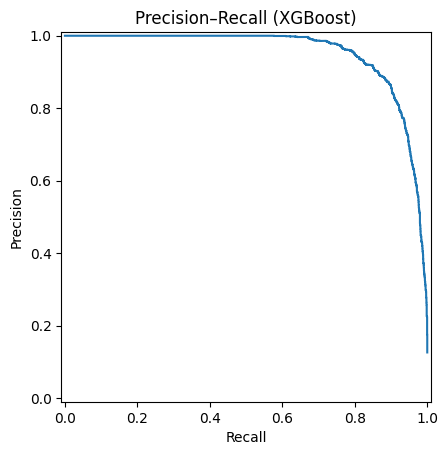

Threshold: 0.953, Precision: 1.000, Recall: 0.578


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Расчёт веса класса для XGBoost
scale = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(x_train, y_train)

# Предсказания и PR-кривая
probs = xgb.predict_proba(x_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision–Recall (XGBoost)')
plt.show()

# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

<h3>4.2 LightGBM</h3>

[LightGBM] [Info] Number of positive: 10491, number of negative: 72778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7189
[LightGBM] [Info] Number of data points in the train set: 83269, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


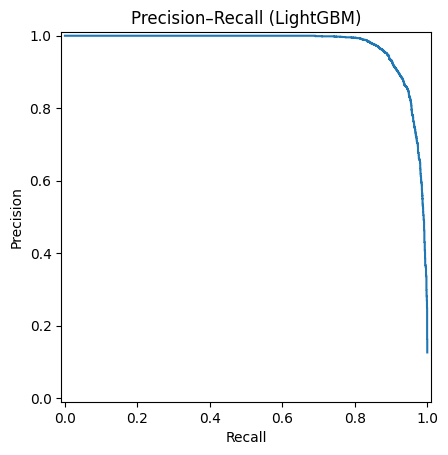

Threshold: 0.958, Precision: 1.000, Recall: 0.692


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Обучение LightGBM модели
lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)
lgbm.fit(x_train, y_train)

# Предсказания и построение PR-кривой
probs = lgbm.predict_proba(x_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision–Recall (LightGBM)')
plt.show()

# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

<h3>4.3 CatBoost</h3>

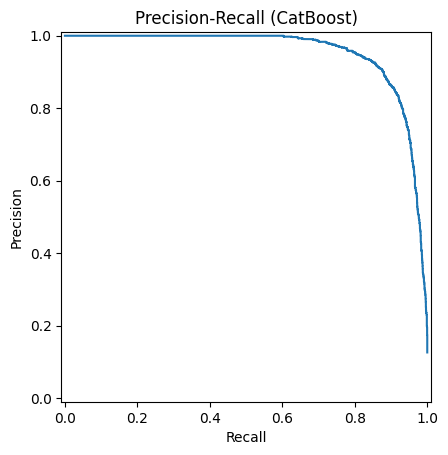

Threshold: 0.935, Precision: 1.000, Recall: 0.604


In [19]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=0,
    random_state=42
)
cb.fit(x_train, y_train)

probs = cb.predict_proba(x_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)
PrecisionRecallDisplay(precision, recall).plot()

plt.title('Precision-Recall (CatBoost)')
plt.show()

# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

<h3>4.4 Keras</h3>

Epoch 1/100


C:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8808 - loss: 0.3123 - val_accuracy: 0.9323 - val_loss: 0.1915
Epoch 2/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9347 - loss: 0.1800 - val_accuracy: 0.9426 - val_loss: 0.1581
Epoch 3/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9464 - loss: 0.1539 - val_accuracy: 0.9513 - val_loss: 0.1413
Epoch 4/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1379 - val_accuracy: 0.9560 - val_loss: 0.1310
Epoch 5/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9583 - loss: 0.1253 - val_accuracy: 0.9589 - val_loss: 0.1234
Epoch 6/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9622 - loss: 0.1174 - val_accuracy: 0.9607 - val_loss: 0.1166
Epoch 7/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9638 - loss: 0.1093 - val_accuracy: 0.9611 - val_loss: 0.1119
Epoch 8/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9665 - loss: 0.1014 - val_accuracy: 0.9643

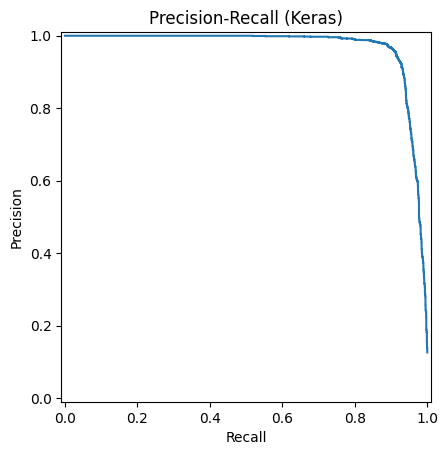

Threshold: 0.998, Precision: 1.000, Recall: 0.520


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, batch_size=256, 
          validation_data=(x_val, y_val), verbose=1)
probs=model.predict(x_val).ravel()
precision, recall, thresholds = precision_recall_curve(y_val, probs)
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision-Recall (Keras)')
plt.show()

# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

Лучший Recall при идеальной точности показал LightGBM.
Фокусируемся на настройке её гиперпараметров для максимизации Recall.

<h2>5 Построение модели</h2>

<h3>5.1 Подбор борьбы с дисбалансом классов</h3>

In [21]:
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score

def evaluate_model(X_train_loc, y_train_loc, description):
    model = lgb.LGBMClassifier(
        n_estimators=100, 
        class_weight='balanced',   # сбалансированные веса 
        random_state=42
    )
    model.fit(X_train_loc, y_train_loc)
    # Предсказания вероятностей на валидации
    y_scores = model.predict_proba(x_val)[:,1]
    # Подберем порог, обеспечивающий Precision=1
    best_recall = 0
    best_thr = 1.0
    for thr in np.linspace(0, 1, 101):
        preds = (y_scores >= thr).astype(int)
        if np.any(preds):  # есть положительные предсказания
            prec = precision_score(y_val, preds)
            rec = recall_score(y_val, preds)
            if prec == 1.0 and rec > best_recall:
                best_recall = rec
                best_thr = thr
    print(f"{description}: Recall@P=1 = {best_recall:.3f} (threshold {best_thr:.3f})")

# 1) Без изменений (class_weight='balanced')
evaluate_model(x_train, y_train, "LightGBM (с class_weight)")

# 2) Undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(x_train, y_train)
evaluate_model(X_rus, y_rus, "LightGBM (undersampled)")

# 3) Oversampling SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x_train, y_train)
evaluate_model(X_sm, y_sm, "LightGBM (SMOTE)")

# 4) Комбинированный (например, class_weight + SMOTE)
evaluate_model(X_sm, y_sm, "LightGBM (SMOTE + class_weight)")


[LightGBM] [Info] Number of positive: 10491, number of negative: 72778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7189
[LightGBM] [Info] Number of data points in the train set: 83269, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM (с class_weight): Recall@P=1 = 0.623 (threshold 0.960)
[LightGBM] [Info] Number of positive: 10491, number of negative: 10491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6488
[LightGBM] [Info] Number of data points in the 

Наилучший результат (максимальный Recall при Precision=1) показал метод SMOTE

<h3>5.2 Подбор параметров</h3>

In [22]:
import numpy as np
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from itertools import product

# 1. Подготовка данных с SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x_train, y_train)

# 2. Сетка гиперпараметров
param_grid = {
    'n_estimators': [200, 300, 392],
    'num_leaves': [31, 63],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [5, 7],
    'min_gain_to_split': [0.0, 0.05],
    'class_weight': ['balanced'],
    'random_state': 42,
    'verbose': -1
}

# Функция выбора лучшей точки на PR-кривой при Recall ≥ threshold

def select_by_recall_precision(precision, recall, thresholds, min_recall=0.1):
    prec = precision[1:]
    rec  = recall[1:]
    th   = thresholds

    mask = rec >= min_recall
    if not mask.any():
        return None, None, None

    valid_prec = prec[mask]
    valid_rec  = rec[mask]
    valid_th   = th[mask]

    max_prec = valid_prec.max()
    candidates = np.where(valid_prec == max_prec)[0]

    if len(candidates) > 1:
        idx = candidates[np.argmax(valid_rec[candidates])]
    else:
        idx = candidates[0]

    return valid_prec[idx], valid_rec[idx], valid_th[idx]

# Список для хранения всех результатов
results = []

# Поиск по сетке гиперпараметров
for ne, nl, md, lr, mcs, mgs, cw in product(
        param_grid['n_estimators'],
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['min_child_samples'],
        param_grid['min_gain_to_split'],
        param_grid['class_weight']
    ):
    params = {
        'n_estimators':      ne,
        'num_leaves':        nl,
        'max_depth':         md,
        'learning_rate':     lr,
        'min_child_samples': mcs,
        'min_gain_to_split': mgs,
        'class_weight':      cw,
        'random_state':      42,
        'verbose':           -1
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_sm, y_sm)

    y_proba = model.predict_proba(x_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

    best_prec, best_rec, best_thr = select_by_recall_precision(
        precision, recall, thresholds, min_recall=0.1
    )

    if best_prec is None:
        results.append({**params, 'precision': None, 'recall': None, 'threshold': None})
        continue

    results.append({**params, 'precision': best_prec, 'recall': best_rec, 'threshold': best_thr})

# Сортировка результатов: сначала по precision, затем по recall (по убыванию)
sorted_results = sorted(
    [r for r in results if r['precision'] is not None],
    key=lambda x: (x['precision'], x['recall']),
    reverse=True
)

# Итоговый лучший результат
best = sorted_results[0] if sorted_results else None
if best:
    print("\n=== BEST OVERALL ===")
    print(f"Precision@R≥0.1 = {best['precision']:.3f}, Recall = {best['recall']:.3f} at threshold = {best['threshold']:.3f}")
    print("Params:", {k: best[k] for k in param_grid.keys()})



=== BEST OVERALL ===
Precision@R≥0.1 = 1.000, Recall = 0.820 at threshold = 0.950
Params: {'n_estimators': 392, 'num_leaves': 63, 'max_depth': 10, 'learning_rate': 0.05, 'min_child_samples': 5, 'min_gain_to_split': 0.0, 'class_weight': 'balanced', 'random_state': 42, 'verbose': -1}


<h3>5.3 Модель с лучшими параметрами</h3>

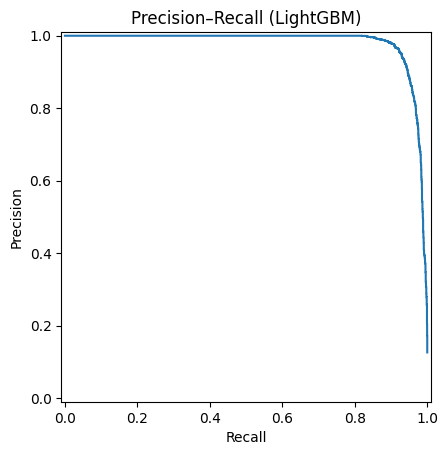

Threshold: 0.952, Precision: 1.000, Recall: 0.820
Confusion Matrix:
 [[18195     0]
 [  473  2150]]
              precision    recall  f1-score   support

           0      0.975     1.000     0.987     18195
           1      1.000     0.820     0.901      2623

    accuracy                          0.977     20818
   macro avg      0.987     0.910     0.944     20818
weighted avg      0.978     0.977     0.976     20818

PR-AUC: 0.980
ROC-AUC: 0.994


In [23]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score
# 1) Инициализируем модель с лучшими параметрами
best_params = {
    'n_estimators': 392,
    'num_leaves': 63,
    'max_depth': 10,
    'learning_rate': 0.05,
    'min_child_samples': 5,
    'min_gain_to_split': 0.0,
    'class_weight': 'balanced',
    'random_state': 42,
    'verbose': -1
}
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_sm, y_sm)



probs = best_model.predict_proba(x_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision–Recall (LightGBM)')
plt.show()


# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

# Предсказания меток по выбранному порогу
y_pred = (probs >= best_threshold).astype(int)

# Матрица неточностей
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)
# Классификационный отчет (точность, полнота и др.)
print(classification_report(y_val, y_pred, digits=3))

# Расчет PR-AUC на валидации
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")
roc_auc = roc_auc_score(y_val, probs)
print(f"ROC-AUC: {roc_auc:.3f}")


<h3>5.4 Итоговые результаты</h3>

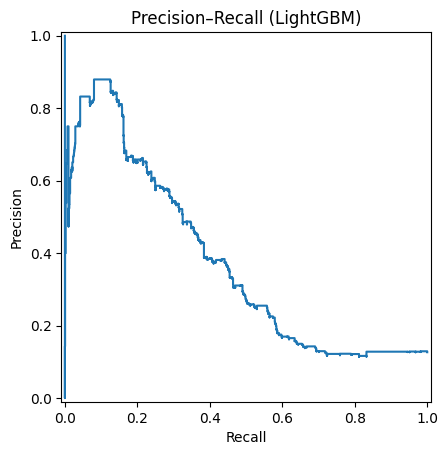

Threshold: 0.919, Precision: 0.879, Recall: 0.125
Confusion Matrix:
 [[12424    31]
 [ 1580   226]]
              precision    recall  f1-score   support

           0      0.887     0.998     0.939     12455
           1      0.879     0.125     0.219      1806

    accuracy                          0.887     14261
   macro avg      0.883     0.561     0.579     14261
weighted avg      0.886     0.887     0.848     14261

PR-AUC: 0.367
ROC-AUC: 0.632


In [24]:
y_test = df_test['target']
x_test = df_test.drop(columns='target')

probs = best_model.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision–Recall (LightGBM)')
plt.show()

# Убираем последнюю точку (где recall = 0 и threshold не определён)
prec = precision[:-1]
rec = recall[:-1]
thr = thresholds

df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'threshold': thr
})
# Отбираем точки с Recall ≥ 0.1
df_valid = df[df['recall'] >= 0.1]
if not df_valid.empty:
    # Сортируем сначала по Precision (убывание), затем по Recall (убывание)
    best_row = df_valid.sort_values(['precision','recall'], ascending=False).iloc[0]
    best_threshold = best_row['threshold']
    best_precision = best_row['precision']
    best_recall = best_row['recall']
    print(f"Threshold: {best_threshold:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
else:
    print("Нет точек с Recall ≥ 0.1")

# Предсказания меток по выбранному порогу
y_pred = (probs >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred, digits=3))

pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC-AUC: {roc_auc:.3f}")
#Экспортируем ее
import joblib
joblib.dump(
    {'model': best_model, 'threshold': best_threshold},
    'lgbm_model_with_threshold.pkl'
);